In [1]:
!python --version

Python 3.9.13


In [4]:
!pip3 install kaggle

  Using cached kaggle-1.5.12-py3-none-any.whl
     |████████████████████████████████| 140 kB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 160 kB 18.1 MB/s eta 0:00:01
  Using cached python_slugify-6.1.2-py2.py3-none-any.whl (9.4 kB)
     |████████████████████████████████| 62 kB 3.7 MB/s  eta 0:00:01
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
     |████████████████████████████████| 61 kB 14.2 MB/s eta 0:00:01


In [10]:
%cd Data

/home/studio-lab-user/sagemaker-studiolab-notebooks/Capstone/Data


In [11]:
!pwd

/home/studio-lab-user/sagemaker-studiolab-notebooks/Capstone/Data


In [6]:
mkdir /home/studio-lab-user/.kaggle

In [8]:
!cp kaggle.json /home/studio-lab-user/.kaggle

In [12]:
!kaggle competitions download -c m5-forecasting-accuracy

 90%|██████████████████████████████████    | 41.0M/45.8M [00:01<00:00, 44.9MB/s]
100%|██████████████████████████████████████| 45.8M/45.8M [00:01<00:00, 39.9MB/s]


In [13]:
!unzip m5-forecasting-accuracy.zip

Archive:  m5-forecasting-accuracy.zip
  inflating: calendar.csv            
  inflating: sales_train_evaluation.csv  
  inflating: sales_train_validation.csv  
  inflating: sample_submission.csv   
  inflating: sell_prices.csv         


In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.tsatools import lagmat

In [2]:
train = pd.read_csv('Data/sales_train_validation.csv')
cal = pd.read_csv('Data/calendar.csv')
prices = pd.read_csv('Data/sell_prices.csv')

In [24]:
train

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


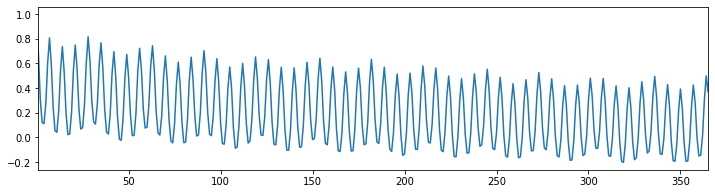

In [135]:
import statsmodels.api as sm
time_series = train.set_index("id")
time_series_sales = time_series.iloc[:,5:]
time_series_array = time_series_sales.to_numpy()
time_series_array_sum = np.sum(time_series_array,axis=0)

def acf2(x, n_lags):
    return sm.tsa.stattools.acf(x, nlags=n_lags)

total_acf_df = pd.DataFrame(list(acf2(time_series_array_sum,365)))

plt.figure(figsize=(12, 3))
plt.xlim((1, 365))
plt.plot(total_acf_df)
plt.show()

In [12]:
time_series = train.set_index("id")
time_series_sales = time_series.iloc[:,5:]

In [32]:
acf(time_series_sales.transpose().iloc[:,0:1],nlags=30)

array([1.        , 0.23059253, 0.21189742, 0.17837335, 0.14812494,
       0.21630753, 0.20763677, 0.20899036, 0.18771827, 0.18308764,
       0.20783138, 0.22811985, 0.20684777, 0.25017705, 0.24115695,
       0.18828286, 0.23084767, 0.2240552 , 0.26731868, 0.20330644,
       0.2090495 , 0.20782611, 0.22700077, 0.23134647, 0.18000134,
       0.20550955, 0.20094471, 0.20863186, 0.21666835, 0.22470484,
       0.21603408])

In [34]:
acf2(time_series_sales.transpose().iloc[:,0:1],n_lags=30)

array([1.        , 0.23059253, 0.21189742, 0.17837335, 0.14812494,
       0.21630753, 0.20763677, 0.20899036, 0.18771827, 0.18308764,
       0.20783138, 0.22811985, 0.20684777, 0.25017705, 0.24115695,
       0.18828286, 0.23084767, 0.2240552 , 0.26731868, 0.20330644,
       0.2090495 , 0.20782611, 0.22700077, 0.23134647, 0.18000134,
       0.20550955, 0.20094471, 0.20863186, 0.21666835, 0.22470484,
       0.21603408])

In [7]:
reduced_cal = cal[cal.weekday=='Sunday']

In [9]:
price_date = prices.merge(reduced_cal,left_on="wm_yr_wk",right_on="wm_yr_wk")

In [10]:
price_date['id'] = price_date['item_id'] + '_' + price_date['store_id'] + '_validation'

In [11]:
price_date = price_date.loc[:,['id', 'sell_price','date']]

In [13]:
time_series_prices = price_date.groupby(['id','date']).mean().unstack()

In [17]:
time_series_sales.to_csv('time_series_sales.csv',index=True)

In [23]:
time_series_sales = pd.read_csv('time_series_sales.csv',index_col=0)

In [24]:
time_series_sales

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_WI_3_validation,0,0,2,2,0,3,1,4,1,0,...,2,0,0,0,0,0,1,0,0,1
FOODS_3_824_WI_3_validation,0,0,0,0,0,5,0,1,1,3,...,0,0,0,0,0,0,0,0,1,0
FOODS_3_825_WI_3_validation,0,6,0,2,2,4,1,8,5,2,...,2,1,0,2,0,1,0,0,1,0


In [31]:
def acf2(x, n_lags):
    return sm.tsa.stattools.acf(x, nlags=n_lags)
n_lags = 365

In [15]:
lag_array = np.repeat(n_lags, time_series_sales.shape[0])

In [18]:
time_series_array = time_series_sales.to_numpy()

In [19]:
time_series_array_sum = np.sum(time_series_array,axis=1)

In [32]:
total_acf_df = pd.DataFrame(list(acf(time_series_array_sum,365)))

In [29]:
total_acf_df

,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,365
0,1.0,0.117299,0.046169,0.070197,0.0732,0.03002,0.07429,0.099577,0.075011,0.082956,...,0.048422,0.019523,0.023896,0.038272,0.082039,0.030556,0.023113,0.021136,0.033673,0.040321


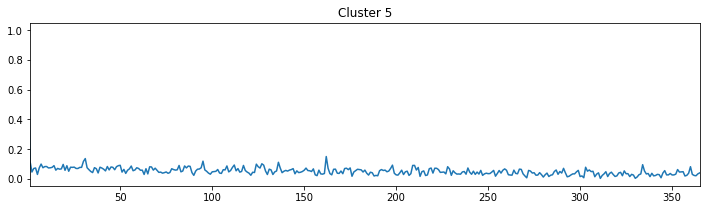

In [33]:
plt.figure(figsize=(12, 3))
plt.xlim((1, n_lags))
plt.plot(total_acf_df)
plt.title(f"Cluster {i}")
plt.show()

In [49]:
acf_list = list(map(acf, time_series_sales.to_numpy(), lag_array))

In [50]:
acf_df = pd.DataFrame(acf_list).transpose()

In [51]:
acf_df.columns = time_series_sales.index

In [52]:
acf_df

id,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.230593,0.125627,0.288903,0.108732,0.238397,0.155965,0.074475,0.154996,0.034998,0.087535,...,0.373863,0.517720,0.107825,0.254451,0.523709,0.515567,0.219352,0.396220,0.398870,0.391214
2,0.211897,0.136811,0.295814,-0.007495,0.137893,0.087232,0.074830,0.100922,0.023868,0.044120,...,0.340776,0.486973,0.062580,0.246054,0.449726,0.475082,0.189185,0.356018,0.364507,0.336896
3,0.178373,0.106056,0.327026,-0.012488,0.092323,0.065850,0.091189,0.100390,0.042145,0.024197,...,0.321541,0.486470,0.052410,0.242069,0.420563,0.468585,0.206973,0.356345,0.307939,0.340001
4,0.148125,0.104336,0.282791,0.024334,0.088265,0.125593,0.045822,0.111694,0.041907,-0.000748,...,0.297296,0.473539,0.034156,0.257978,0.402800,0.430214,0.184295,0.362881,0.318607,0.324961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,0.098875,0.080552,0.026107,-0.046976,0.002900,-0.054236,0.006873,0.027440,0.031391,-0.033965,...,0.047245,0.011249,-0.013187,0.063307,0.048798,-0.017251,0.032618,-0.021727,-0.003546,0.098604
362,0.095424,0.043761,0.043730,-0.017816,-0.001158,-0.062254,0.054095,0.016099,0.055168,-0.004634,...,0.028062,0.016126,0.043124,0.071596,0.053854,-0.014340,0.050407,-0.028542,-0.018325,0.109748
363,0.123160,0.105365,0.014960,0.056445,0.008528,-0.062500,0.004614,0.048872,0.021497,-0.014361,...,0.031932,0.034711,0.035458,0.116832,0.058211,-0.011429,0.064304,-0.016828,-0.008222,0.078349
364,0.132310,0.108899,0.025956,0.142234,0.079380,-0.047234,0.027145,-0.002059,0.027700,0.065627,...,0.086065,0.016450,0.064119,0.098880,0.076496,-0.010782,0.047852,-0.001271,-0.015650,0.122887


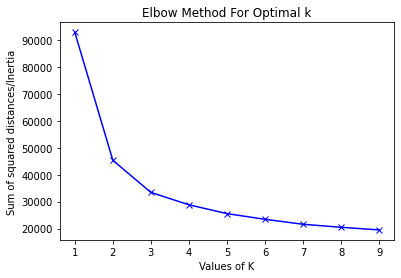

In [53]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(acf_df.transpose())
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

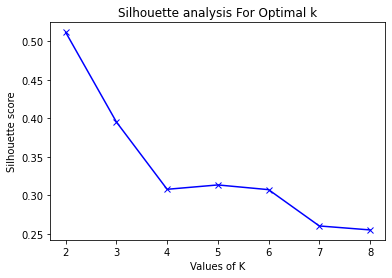

In [61]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(acf_df.transpose())
    cluster_labels = kmeans.labels_
 
 # silhouette score
    silhouette_avg.append(silhouette_score(acf_df.transpose(), cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [37]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(clustered_df)
kmeans.labels_

array([3, 0, 1, ..., 4, 2, 3], dtype=int32)

In [66]:
clustered_df = acf_df.transpose()

In [67]:
clustered_df['cluster'] = kmeans.labels_

In [39]:
sample_df = clustered_df[clustered_df['cluster']==0].sample(10)
for i in range(1,n_clusters):
    sample_df = pd.concat([sample_df, clustered_df[clustered_df['cluster']==i].sample(10)], ignore_index=False)

In [44]:
to_plot.transpose().iloc[:365,0].shape

(365,)

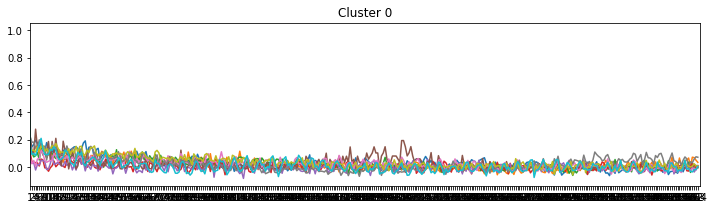

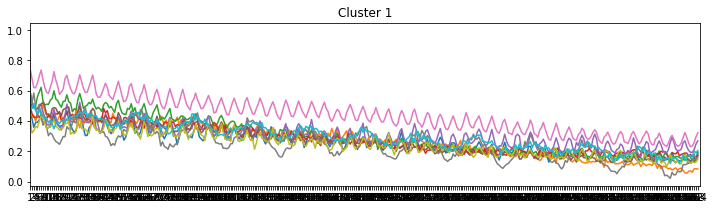

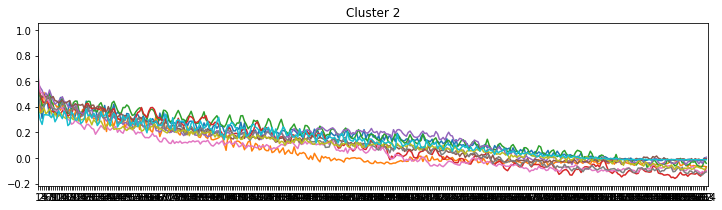

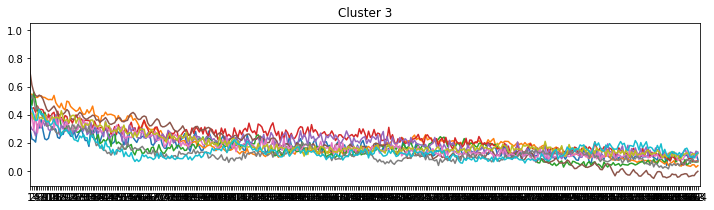

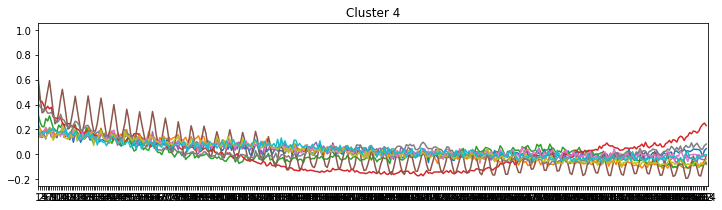

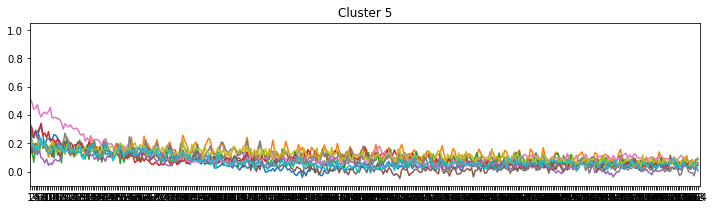

In [47]:
for i in range(n_clusters):
    plt.figure(figsize=(12, 3))
    plt.xlim((1, 365))
    to_plot = sample_df[sample_df.cluster==i]
    for j in range(len(to_plot)):
        plt.plot(to_plot.transpose().iloc[:365,j])
    plt.title(f"Cluster {i}")
    plt.show()

In [132]:
top = []
ranking_df = pd.DataFrame(index=range(1,366),data={'lag':range(1,366),'score':np.repeat(0,365)})
cluster = clustered_df[clustered_df.cluster==4]
for j in range(cluster.T.shape[1]):
    new_ranking = abs(cluster.T.iloc[1:366,j]).sort_values(ascending=False).index
    new_ranking = [int(i) for i in new_ranking]
    score = pd.DataFrame(data={'lag':new_ranking,'points':range(365,0,-1)}).sort_values(by='lag').set_index('lag')
    ranking_df['score'] = ranking_df['score'] + score['points']

In [133]:
ranking_df.sort_values(by='score',ascending=False).head(10)

,lag,score
1,1,1288428
7,7,1279167
6,6,1275426
2,2,1269996
8,8,1267057
5,5,1262092
14,14,1256379
4,4,1255491
3,3,1254932
13,13,1248603


In [107]:
ranking_df.sort_values(by='score',ascending=False).head(20)

,lag,score
1,1,471702
7,7,470023
6,6,467236
8,8,464125
14,14,462774
2,2,460531
5,5,458754
21,21,458292
13,13,457281
28,28,456402


In [119]:
cluster = clustered_df[clustered_df.cluster==0]
cluster.T.iloc[0:366,0]

0      1.000000
1      0.125627
2      0.136811
3      0.106056
4      0.104336
         ...   
361    0.080552
362    0.043761
363    0.105365
364    0.108899
365    0.097501
Name: HOBBIES_1_002_CA_1_validation, Length: 366, dtype: float64

In [114]:
ranking

Index(['221', '249', '278', '272', '276', '187', '120', '281', '300', '223',
       ...
       '361', '365', '4', '363', '3', '364', '1', '2', '5', '0'],
      dtype='object', length=367)

In [95]:
score = score.set_index('lag')

In [96]:
score

,points
lag,
1,365
2,350
3,358
4,352
5,360
...,...
361,26
362,19
363,62


In [101]:
ranking_df = pd.DataFrame(index=range(1,366),data={'lag':range(1,366),'score':np.repeat(0,365)})
ranking_df['score'] = ranking_df['score'] + score['points']
ranking_df

,lag,score
1,1,365
2,2,350
3,3,358
4,4,352
5,5,360
...,...,...
361,361,26
362,362,19
363,363,62
364,364,99


In [71]:
pd.DataFrame(data={'lag':cluster.T.iloc[:,0].sort_values(ascending=False).index[2:],'points':range(365,0,-1)})

,lag,points
0,1,365
1,8,364
2,6,363
3,7,362
4,17,361
...,...,...
360,331,5
361,164,4
362,263,3
363,165,2


In [82]:
abs(cluster.T.iloc[:,0]).sort_values(ascending=False)

cluster    4.000000
0          1.000000
1          0.270680
8          0.266275
6          0.264351
             ...   
125        0.002254
345        0.002136
221        0.002071
294        0.001737
290        0.000379
Name: HOBBIES_1_021_CA_1_validation, Length: 367, dtype: float64

In [87]:
new_ranking = abs(cluster.T.iloc[:,0]).sort_values(ascending=False).index[2:]
new_ranking = [int(i) for i in new_ranking]
score = pd.DataFrame(data={'lag':new_ranking,'points':range(365,0,-1)}).sort_values(by='lag')
score

,lag,points
0,1,365
15,2,350
7,3,358
13,4,352
5,5,360
...,...,...
339,361,26
346,362,19
303,363,62
266,364,99


In [85]:
new_ranking = abs(cluster.T.iloc[:,0]).sort_values().index[2:]
new_ranking

Index(['221', '345', '125', '128', '208', '253', '177', '270', '313', '130',
       ...
       '3', '11', '5', '17', '7', '6', '8', '1', '0', 'cluster'],
      dtype='object', length=365)

In [35]:
clustered_df = pd.read_csv('clustered_df.csv',index_col='id')